0. Import thư viện & load dataset

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, accuracy_score,confusion_matrix,ConfusionMatrixDisplay,classification_report

In [5]:
df = pd.read_csv('Datasets/google-play-kaggle/Google-Playstore.csv')

Review dataset

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2312944 entries, 0 to 2312943
Data columns (total 24 columns):
 #   Column             Dtype  
---  ------             -----  
 0   App Name           object 
 1   App Id             object 
 2   Category           object 
 3   Rating             float64
 4   Rating Count       float64
 5   Installs           object 
 6   Minimum Installs   float64
 7   Maximum Installs   int64  
 8   Free               bool   
 9   Price              float64
 10  Currency           object 
 11  Size               object 
 12  Minimum Android    object 
 13  Developer Id       object 
 14  Developer Website  object 
 15  Developer Email    object 
 16  Released           object 
 17  Last Updated       object 
 18  Content Rating     object 
 19  Privacy Policy     object 
 20  Ad Supported       bool   
 21  In App Purchases   bool   
 22  Editors Choice     bool   
 23  Scraped Time       object 
dtypes: bool(4), float64(4), int64(1), object(15)
memor

Preprocessing

In [8]:
non_null_df = df[~df.isnull().any(axis=1)]
non_null_df.reset_index(drop=True, inplace=True)
non_null_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1287191 entries, 0 to 1287190
Data columns (total 24 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   App Name           1287191 non-null  object 
 1   App Id             1287191 non-null  object 
 2   Category           1287191 non-null  object 
 3   Rating             1287191 non-null  float64
 4   Rating Count       1287191 non-null  float64
 5   Installs           1287191 non-null  object 
 6   Minimum Installs   1287191 non-null  float64
 7   Maximum Installs   1287191 non-null  int64  
 8   Free               1287191 non-null  bool   
 9   Price              1287191 non-null  float64
 10  Currency           1287191 non-null  object 
 11  Size               1287191 non-null  object 
 12  Minimum Android    1287191 non-null  object 
 13  Developer Id       1287191 non-null  object 
 14  Developer Website  1287191 non-null  object 
 15  Developer Email    1287191 non-n

Encoding

* App Name         str
* Category         str -> int
* Rating           float
* Rating Count     float
* Minimum Installs float
* Maximum Installs int
* Free             bool
* Price            float
* Size             str -> float
* Minimum Android  str -> int
* Released         str -> date
* Last Updated     str -> date
* Content Rating   str -> int
* Ad Supported     bool
* In App Purchases bool
* Editors Choice   bool

Category

In [9]:
encoded_df = non_null_df
encoded_df[['Category', 'Content Rating']] = non_null_df[['Category', 
                                                           'Content Rating']].apply(LabelEncoder().fit_transform)

Size

In [10]:
def size_convert2float(data):
    data=data.replace(',','')
    num=data[:-1]
    if data[-1]=='K' or data[-1]=='k' :
        return float(num)
    elif data[-1]=='M' or data[-1]=='m':
        return float(num)*1000
    elif data[-1]=='G' or data[-1]=='g':
        return float(num)*1000000
    else:
        return 1000

In [11]:
encoded_df['Size'] = non_null_df['Size'].apply(size_convert2float)

Minimum Android

In [12]:
def min_android(data):
    p=data.split()
    if data=='Varies with device':
        return 4.0
    else:
        return float(p[0][:3])

In [13]:
encoded_df['Minimum Android'] = non_null_df['Minimum Android'].apply(min_android)

Days_alive = Last Updated - Released

In [14]:
encoded_df['Released'] = pd.to_datetime(non_null_df['Released'], format='%b %d, %Y',
                                 infer_datetime_format=True, errors='coerce')

In [15]:
encoded_df['Last Updated'] = pd.to_datetime(non_null_df['Last Updated'], format='%b %d, %Y',
                                 infer_datetime_format=True, errors='coerce')

In [16]:
encoded_df['Days_alive'] = (non_null_df['Last Updated'] 
                            - non_null_df['Released']).dt.days

In [17]:
encoded_df['Content Rating'].unique

<bound method Series.unique of 0          1
1          1
2          1
3          4
4          1
          ..
1287186    1
1287187    1
1287188    1
1287189    1
1287190    1
Name: Content Rating, Length: 1287191, dtype: int32>

<AxesSubplot:>

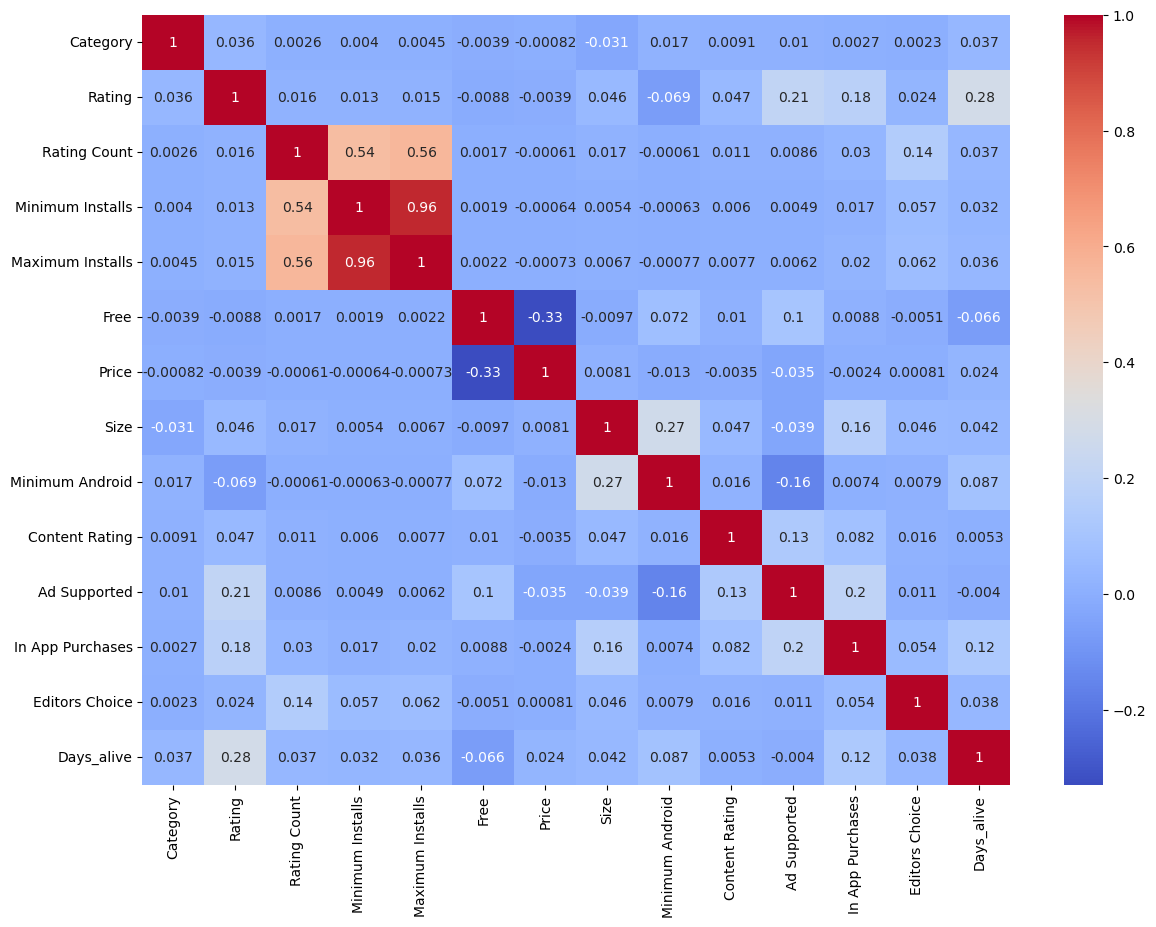

In [18]:
# Correlation matrix
plt.figure(figsize=(14,10))
sns.heatmap(encoded_df.corr(), annot=True, cmap='coolwarm')

# Regression Models

Dự đoán số lượt cài đặt:
- Thuộc tính Free ảnh hưởng rất lớn tới đầu ra Maximum Installs
- Chia ra làm 2 mô hình dự đoán cho Free apps và Paid apps

Train test split

In [19]:
X = encoded_df[['Category', 'Free', 'Price', 'Size', 'Minimum Android', 
                           'Content Rating', 'Ad Supported', 'In App Purchases', 
                           'Editors Choice', 'Days_alive']]

y = encoded_df['Maximum Installs']

In [20]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.3, random_state=0)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((901033, 10), (386158, 10), (901033,), (386158,))

Modeling

In [22]:
model_1=LinearRegression()
model_1.fit(X_train,y_train)
print('r2_score of training data',r2_score(model_1.predict(X_train).round(1),y_train))
print('r2_score of testing data',r2_score(model_1.predict(X_test).round(1),y_test))

r2_score of training data -228.0942829619768
r2_score of testing data -185.78226620877604


In [23]:
model_2=DecisionTreeRegressor(max_depth=9)
model_2.fit(X_train,y_train)
print('r2_score of training data',r2_score(model_2.predict(X_train).round(1),y_train))
print('r2_score of testing data',r2_score(model_2.predict(X_test).round(1),y_test))

r2_score of training data 0.5416680629711631
r2_score of testing data -0.8140093955350642


In [26]:
from xgboost import XGBRegressor
model_4=XGBRegressor()
model_4.fit(X_train,y_train)
print('r2_score of training data',r2_score(model_4.predict(X_train).round(1),y_train))
print('r2_score of testing data',r2_score(model_4.predict(X_test).round(1),y_test))

r2_score of training data -2.2859412985073293
r2_score of testing data -3.602786036838979


Dự đoán rating:

Train test split

In [ ]:
X = encoded_df[['Category', 'Rating Count', 'Maximum Installs', 
                           'Free', 'Price', 'Size', 'Minimum Android', 
                           'Content Rating', 'Ad Supported', 'In App Purchases', 
                           'Editors Choice', 'Days_alive']]

y = encoded_df['Rating']

In [ ]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.3, random_state=0)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((901033, 12), (386158, 12), (901033,), (386158,))

Modeling

In [ ]:
model_1=LinearRegression()
model_1.fit(X_train,y_train)
print('r2_score of training data',r2_score(model_1.predict(X_train).round(1),y_train))
print('r2_score of testing data',r2_score(model_1.predict(X_test).round(1),y_test))

r2_score of training data -5.120196245590867
r2_score of testing data -5.104771173944716


In [ ]:
model_2=DecisionTreeRegressor(max_depth=9)
model_2.fit(X_train,y_train)
print('r2_score of training data',r2_score(model_2.predict(X_train).round(1),y_train))
print('r2_score of testing data',r2_score(model_2.predict(X_test).round(1),y_test))

r2_score of training data 0.9424843646316237
r2_score of testing data 0.9421417842651739


Dự đoán mức độ tăng trưởng (Số lượt tải & số ứng dụng được public trong tương lai)

In [27]:
df['Released'] = pd.to_datetime(df['Released'], format='%b %d, %Y',
                                 infer_datetime_format=True, errors='coerce')

In [28]:
timeline = df['Released'].value_counts().sort_index()

Tổng số ứng dụng trên Google Play ở thời điểm cụ thể

In [29]:
from datetime import date, datetime, timedelta

total_apps_time_series = []
total_apps_until_then = 0

for timestamp, new_apps_in_that_date in timeline.iteritems():
    total_apps_until_then += new_apps_in_that_date
    total_apps_time_series.append(total_apps_until_then)

Text(0.5, 0, 'Time')

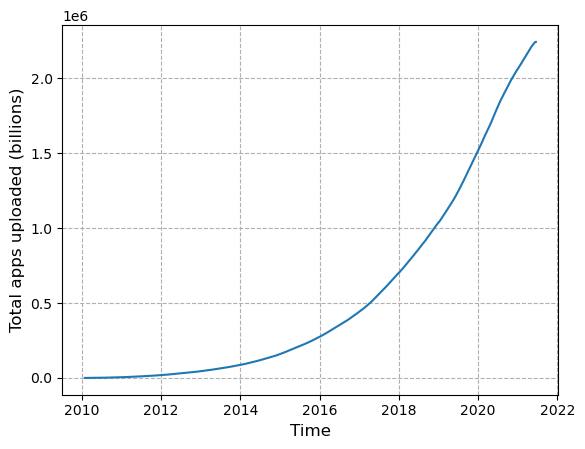

In [38]:
#Hiển thị dữ liệu gốc
plt.plot(timeline.index, total_apps_time_series)
plt.grid(linestyle='--')
plt.ylabel('Total apps uploaded (millions)',fontsize=12)
plt.xlabel('Time',fontsize=12)

ARIMA

In [31]:
from pmdarima import auto_arima
  
stepwise_fit = auto_arima(total_apps_time_series, start_p = 1, start_q = 1,
                          max_p = 3, max_q = 3, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   
                          suppress_warnings = True, 
                          stepwise = True)         
  
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=52260.579, Time=7.11 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=57141.361, Time=0.21 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=55070.183, Time=2.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=52332.843, Time=2.80 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=54898.413, Time=1.47 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=52123.150, Time=5.77 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=53810.638, Time=3.71 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=inf, Time=59.30 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=79.27 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=inf, Time=50.08 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=52723.916, Time=16.11 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=inf, Time=68.40 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=52263.671, Time=5.71 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=18.24 sec
 ARIMA(2,1,1)(1,1,1)[12]     

Traceback (most recent call last):
  File "C:\Users\DUY LINH\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 2057, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "C:\Users\DUY LINH\AppData\Roaming\Python\Python39\site-packages\IPython\core\ultratb.py", line 1288, in structured_traceback
    return FormattedTB.structured_traceback(
  File "C:\Users\DUY LINH\AppData\Roaming\Python\Python39\site-packages\IPython\core\ultratb.py", line 1177, in structured_traceback
    return VerboseTB.structured_traceback(
  File "C:\Users\DUY LINH\AppData\Roaming\Python\Python39\site-packages\IPython\core\ultratb.py", line 1030, in structured_traceback
    formatted_exception = self.format_exception_as_a_whole(etype, evalue, etb, number_of_lines_of_context,
  File "C:\Users\DUY LINH\AppData\Roaming\Python\Python39\site-packages\IPython\core\ultratb.py", line 935, in format_exception_as_a_whole
    self.get_records(etb, number_of_lines_of_c

Unexpected exception formatting exception. Falling back to standard exception


AttributeError: Memoryview is not initialized

In [32]:
#Dự báo với mô hình ARIMA
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

In [33]:
X = total_apps_time_series
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]

In [34]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
  
model = SARIMAX(train, 
                order = (1, 2, 1))
  
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2910
Model:               SARIMAX(1, 2, 1)   Log Likelihood              -16703.702
Date:                Sun, 17 Sep 2023   AIC                          33413.404
Time:                        17:52:09   BIC                          33431.330
Sample:                             0   HQIC                         33419.862
                               - 2910                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4269      0.012     35.320      0.000       0.403       0.451
ma.L1         -0.9732      0.003   -380.378      0.000      -0.978      -0.968
sigma2      5707.3879     80.773     70.660      0.000    5549.076    5865.699
===================================================================================
Ljung-Box (L1) (Q):                 113.02   Jarque-Bera (JB):              7033.85
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              88.22   Skew:                            -0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
start = len(train)
end = len(train) + len(test) - 1
  
# Predictions for one-year against the test set
predictions = result.predict(start, end,
                             typ = 'levels')
predictions

array([ 713550.13876844,  714346.18663082,  715127.6818767 , ...,
       1673061.26989484, 1673831.92598071, 1674602.58206658])

In [ ]:

history = [i for i in train]
predictions = []
#Dự báo 1 bước thời gian
for t in range(len(test)):
	model = ARIMA(history, order=(1,1,1)) #cài đặt p(AR), d(I), q(MA)
	model_fit = model.fit()
	output = model_fit.forecast()# Dự báo cho toàn bộ chuỗi thời gian
	y_pred = output[0] # Giá trị dự báo t+1
	predictions.append(y_pred)
	obs = test[t]
	history.append(obs)
	print('Giá trị dự báo=%f, Giá trị thực tế=%f' % (y_pred, obs)) # Hiển thị giá trị dự báo của từng bước thời gian
# evaluate forecasts
mse=mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('MSE: %.2f' % mse)
print('RMSE: %.2f' % rmse)

Giá trị dự báo=713653.026829, Giá trị thực tế=713676.000000
Giá trị dự báo=714593.930476, Giá trị thực tế=714570.000000
Giá trị dự báo=715419.243638, Giá trị thực tế=715471.000000
Giá trị dự báo=716342.263576, Giá trị thực tế=716303.000000
Giá trị dự báo=717089.986840, Giá trị thực tế=716873.000000
Giá trị dự báo=717373.170631, Giá trị thực tế=717451.000000
Giá trị dự báo=718018.479295, Giá trị thực tế=718318.000000
Giá trị dự báo=719207.172997, Giá trị thực tế=719375.000000
Giá trị dự báo=720419.566388, Giá trị thực tế=720280.000000
Giá trị dự báo=721115.563037, Giá trị thực tế=721220.000000
Giá trị dự báo=722139.431673, Giá trị thực tế=721962.000000
Giá trị dự báo=722634.727510, Giá trị thực tế=722531.000000
Giá trị dự báo=723053.008908, Giá trị thực tế=723172.000000
Giá trị dự báo=723808.432762, Giá trị thực tế=724130.000000
Giá trị dự báo=725111.925010, Giá trị thực tế=725139.000000
Giá trị dự báo=726108.667256, Giá trị thực tế=726102.000000
Giá trị dự báo=727020.715141, Giá trị th

In [ ]:
start_date = '2021-06-17'
end_date = '2026-06-17'

date_index = pd.date_range(start=start_date, end=end_date, freq='D')

last_scraped_day = timeline.count()
future = model_fit.predict(last_scraped_day, last_scraped_day + date_index.size - 1)

In [ ]:
model_fit.forecast()

array([2241910.38153221])

In [1]:
#Hiển thị dữ liệu trong test set và dữ liệu dự báo
plt.plot(timeline.index, total_apps_time_series,'-', markersize=8)
plt.plot(timeline.index[size:len(X)],predictions,'-', markersize=8)
plt.grid(linestyle='--')
plt.ylabel('Doanh số ($)',fontsize=12)
plt.xlabel('Days',fontsize=12)
plt.legend(['Thực tế','Dự báo'])

NameError: name 'plt' is not defined